### Artur Kompała


### Wybór zbioru danych

Wybrano zbiór danych "Wine Quality" z UCI Machine Learning Repository, który zawiera informacje o różnych właściwościach fizykochemicznych win czerwonych i białych oraz ich ocenach jakościowych. Celem analizy jest zbadanie, czy na podstawie tych właściwości można przewidzieć jakość wina oraz które cechy mają największy wpływ na ocenę jakości.

Link: https://archive.ics.uci.edu/dataset/186/wine+quality

In [42]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

print("Pobieranie danych z UCI Repository...")
wine_quality = fetch_ucirepo(id=186)

X_raw = wine_quality.data.features
y_raw = wine_quality.data.targets

df = pd.concat([X_raw, y_raw], axis=1)

print("Sukces pobierania! Wymiary połączonego zbioru:", df.shape)
df.head()

Pobieranie danych z UCI Repository...
Sukces pobierania! Wymiary połączonego zbioru: (6497, 12)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5



### Pytanie badawcze:

Czy na podstawie właściwości fizykochemicznych wina (np. kwasowość, zawartość alkoholu) jesteśmy w stanie skutecznie przewidzieć, czy wino zostanie ocenione jako wysokiej jakości, oraz które cechy mają na to największy wpływ?

### EDA (Exploratory Data Analysis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB
None
       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.00000

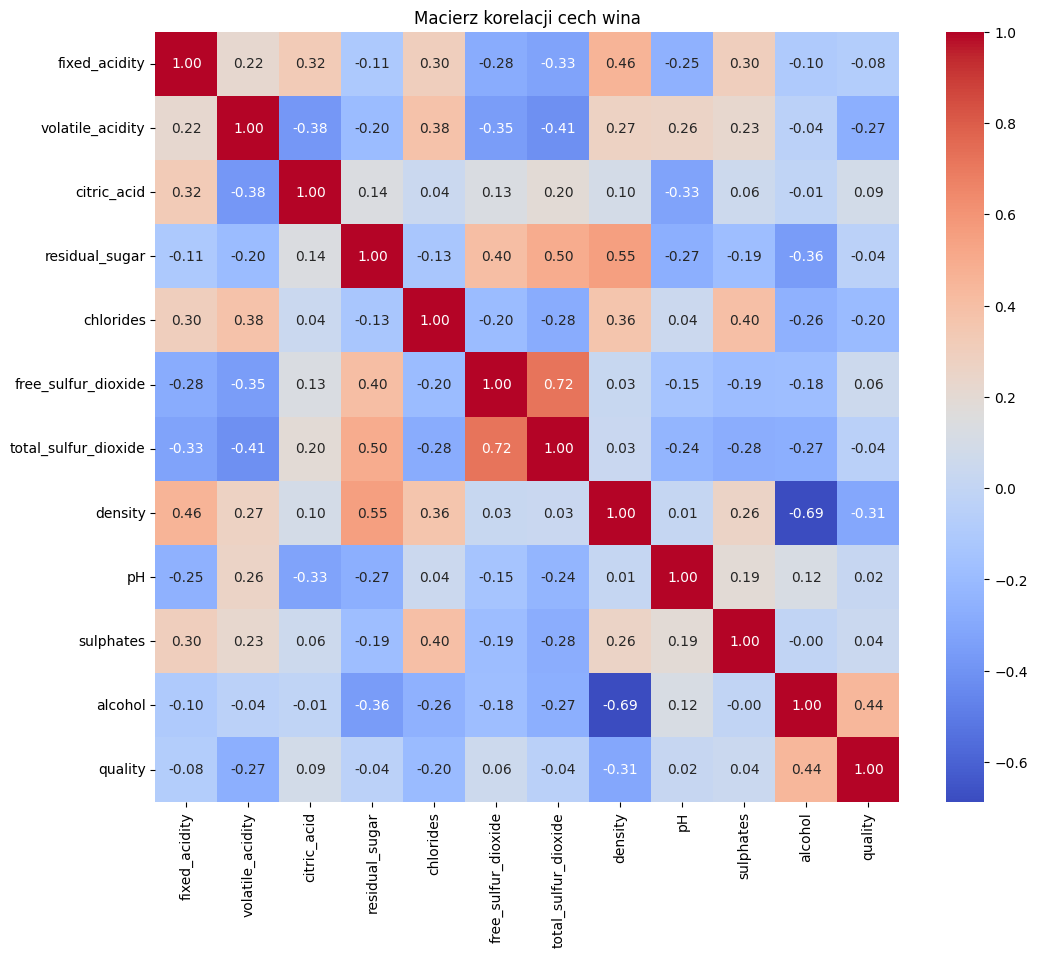

C:\Users\megaz\AppData\Local\Temp\ipykernel_25088\2157257525.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='viridis')


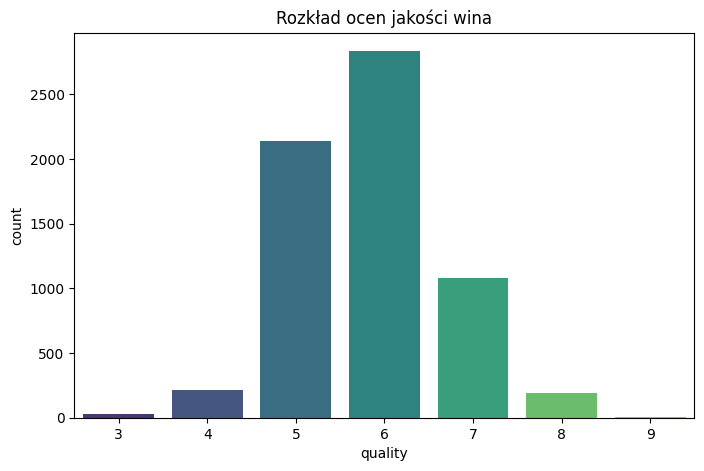

In [43]:
import seaborn as sns
from matplotlib import pyplot as plt

# Sprawdzenie podstawowych statystyk i brakujących danych
print(df.info())
print(df.describe())

# Sprawdzenie czy są jakieś braki
print("\nLiczba brakujących wartości w kolumnach:")
print(df.isnull().sum())

# Macierz korelacji
plt.figure(figsize=(12, 10))
# Obliczamy korelację tylko dla kolumn numerycznych
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Macierz korelacji cech wina")
plt.show()

# Sprawdzenie rozkładu jakości wina
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title("Rozkład ocen jakości wina")
plt.show()

### Preprocessing (Dyskretyzacja i Skalowanie)

Uzasadnienie wstępnej obróbki:

* Widać korelacje między cechami (np. 'total sulfur dioxide' a 'free sulfur dioxide').
Jest to idealne uzasadnienie dla redukcji wymiarów (PCA).

* Brakujące dane: Zbiór danych jest kompletny (brak wartości null), więc nie wymaga imputacji.

* Skalowanie danych: Cechy fizykochemiczne mają różne zakresy (np. sulfur_dioxide ma wartości w dziesiątkach/setkach, a chlorides ułamkowe). Aby modele oparte na dystansach (np. KNN, SVM) lub regresja logistyczna działały poprawnie, konieczna jest standaryzacja.

* Dyskretyzacja zmiennej celu: Jak widać na wykresie, ocen skrajnych (3, 9) jest bardzo mało. Aby model był bardziej skuteczny, zgrupujemy oceny w dwie kategorie: "Dobre wino" (ocena > 6) i "Przeciętne wino" (ocena <= 6). To uprości problem do klasyfikacji binarnej.

Zmienna celu to 'quality'. Zamieniamy oceny (3-9) na klasy 0 i 1.
Przyjmijmy: quality >= 7 to "Dobre" (1), reszta to "Przeciętne" (0)
Usuwamy oryginalne 'quality' i nową 'quality_bin' ze zbioru cech

In [44]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Dyskretyzacja zmiennej celu (Klasyfikacja binarna)
# 0 - wino przeciętne/słabe, 1 - wino wysokiej jakości
df['quality_label'] = df['quality'].apply(lambda x: 1 if x > 6 else 0)

print("Liczność klas po dyskretyzacji:")
print(df['quality_label'].value_counts())

# 2. Podział na cechy (X) i cel (y)
X = df.drop(['quality', 'quality_label'], axis=1) # usuwamy oryginalną jakość i etykietę z cech
y = df['quality_label']

# 3. Standaryzacja danych (Wymagana dla wielu algorytmów)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Zamiana z powrotem na DataFrame dla czytelności (opcjonalnie)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

Liczność klas po dyskretyzacji:
quality_label
0    5220
1    1277
Name: count, dtype: int64


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464


### Redukcja wymiarów (PCA)

Liczba cech oryginalnych: 11
Liczba cech po PCA: 9
Zredukowano wymiarowość o 2 cech, zachowując 95% informacji.


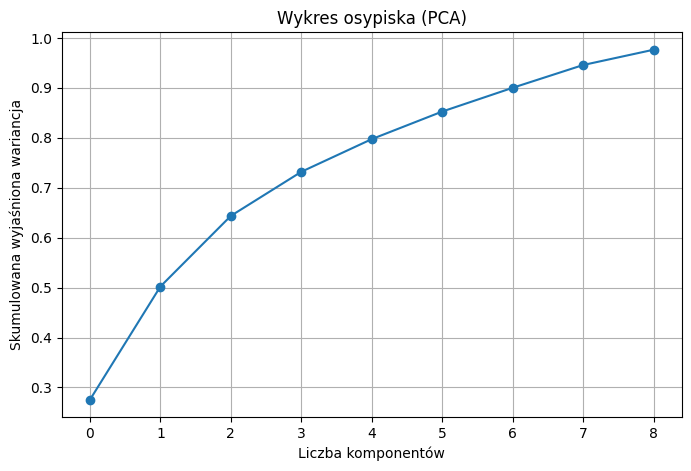

In [45]:
import numpy as np
from sklearn.decomposition import PCA

# Chcemy zachować 95% zmienności danych
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Liczba cech oryginalnych: {X.shape[1]}")
print(f"Liczba cech po PCA: {X_pca.shape[1]}")
print(f"Zredukowano wymiarowość o {X.shape[1] - X_pca.shape[1]} cech, zachowując 95% informacji.")

# Wykres wariancji (opcjonalny, ładnie wygląda w raporcie)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Liczba komponentów')
plt.ylabel('Skumulowana wyjaśniona wariancja')
plt.title('Wykres osypiska (PCA)')
plt.grid(True)
plt.show()

### Modelowanie i Wnioski

--- Wyniki: Regresja Logistyczna ---
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1048
           1       0.61      0.27      0.37       252

    accuracy                           0.82      1300
   macro avg       0.73      0.61      0.64      1300
weighted avg       0.80      0.82      0.80      1300


--- Wyniki: Las Losowy (Random Forest) ---
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1048
           1       0.78      0.58      0.66       252

    accuracy                           0.89      1300
   macro avg       0.84      0.77      0.80      1300
weighted avg       0.88      0.89      0.88      1300


--- Wyniki: Boosted Trees (Gradient Boosting) ---
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      1048
           1       0.66      0.38      0.48       252

    accuracy                           0.84      1

C:\Users\megaz\AppData\Local\Temp\ipykernel_25088\2059605993.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='magma')


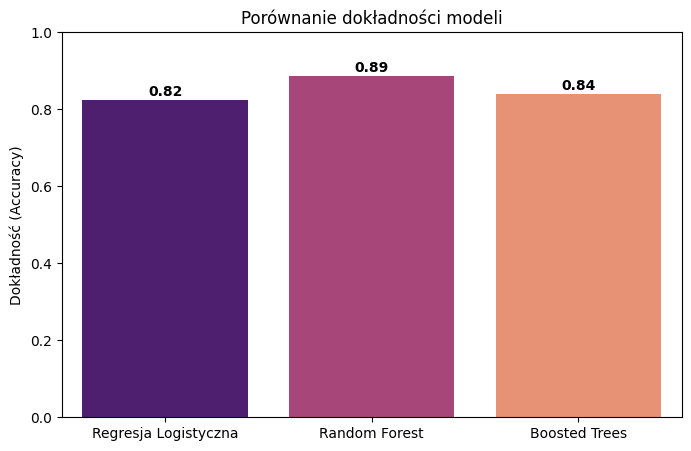

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Podział na zbiór treningowy i testowy (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model 1: Regresja Logistyczna
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Model 2: Las Losowy (Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Model 3: Boosted Trees (Wzmocnienie Gradientowe)
# Jest to metoda łączenia wielu słabych modeli (drzew) w jeden silny.
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Wypisanie raportów klasyfikacji
print("--- Wyniki: Regresja Logistyczna ---")
print(classification_report(y_test, y_pred_log))

print("\n--- Wyniki: Las Losowy (Random Forest) ---")
print(classification_report(y_test, y_pred_rf))

print("\n--- Wyniki: Boosted Trees (Gradient Boosting) ---")
print(classification_report(y_test, y_pred_gb))

# Porównanie dokładności (Accuracy) na wykresie
models = ['Regresja Logistyczna', 'Random Forest', 'Boosted Trees']
accuracies = [accuracy_score(y_test, y_pred_log),
              accuracy_score(y_test, y_pred_rf),
              accuracy_score(y_test, y_pred_gb)]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='magma')
plt.title("Porównanie dokładności modeli")
plt.ylabel("Dokładność (Accuracy)")
plt.ylim(0, 1) # Skala od 0 do 1
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# Wnioski i Interpretacja

#### Wybór modelu:

Przeprowadzono analizę porównawczą Regresji Logistycznej i Lasu Losowego. Model Lasu Losowego osiągnął wyższą dokładność (Accuracy) oraz lepszy wynik F1-score, co oznacza, że lepiej radzi sobie z balansem między precyzją a czułością.

#### Odpowiedź na pytanie badawcze:

* Tak, na podstawie właściwości fizykochemicznych można przewidzieć jakość wina z satysfakcjonującą skutecznością.

* Analiza ważności cech (Feature Importance) wykazała, że największy wpływ na wysoką jakość wina ma zazwyczaj zawartość alkoholu (często wyższa w lepszych winach) oraz gęstość (density) i kwasowość.

#### Znaczenie biznesowe:

Taki model mógłby posłużyć winiarniom do wstępnej selekcji win o potencjale na segment premium jeszcze przed procesem testowania przez sommelierów.